### **패키지 불러오기**

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET #et
import time
import requests

from bs4 import BeautifulSoup
import matplotlib.patches as patches
import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
# import glob

### **directory 연결**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# path of images directory
dir_path  = '../gdrive/My Drive/detection_miniproject/archive/images'

# path of xml files directory
xml_path = "../gdrive/My Drive/detection_miniproject/archive/annotations"

#List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


### **함수 정의**
- **read_annot** : xml 파일을 일어오는 함수
- **draw_boxes**:  bounding box를 그리는 함수

In [ ]:
def read_annot(file_name, xml_dir): # file_name, xml_dir을 input으로 받아 bbox, labels를 return 
    
    bbox = [] # 마스크의 바운딩 박스 좌표를 담음
    labels = [] # with_mask면 2, no_mask 1, mask_weared_incorrect 3
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()

    # 각 마스크의 바운딩 박스 좌표
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text

        bbox.append([xmin,ymin,xmax,ymax])

        if label == 'with_mask':
            label_idx = 2
        elif label == 'without_mask':
            label_idx = 1
        else :
            label_idx = 3
        labels.append(label_idx)
        
    return bbox, labels

def draw_boxes(img, boxes, labels, thickness=1): # thickness : bounding box의 두께 1로 지정
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    text = []
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2: # with_mask 면 초록색 bounding box
            color = (0,225,0) # green
            text.append("with_mask")
        elif label == 1: # with_mask가 아니면 빨간색 bounding box
            color = (0,0,225) # red
            text.append("without_mask")
        else : #weared_incorrect면 오렌지색 bounding box
            color = (0,215,255) #orange
            text.append("mask_weared_incorrect")
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), box[0], box[1], text

### **Class 정의**

In [ ]:
class dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir

    def __len__(self): # 데이터 세트의 크기를 제공하는 메소드
     return len(self.image_list)
       
    def __getitem__(self, idx): 
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        # target : dictionary형태로 생성
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    


### **데이터셋 생성**

In [ ]:
mask_dataset = dataset(file_list, dir_path, xml_path)

# 학습 데이터를 학습용 모델에 일괄적으로 업로드, 이를 위해 PyTorch의 DataLoader 유틸리티 사용
def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=10,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

### **모델 불러오기**

In [ ]:
def get_model(num_classes) :
    # output_shape에 원하는 클래스 개수를 설정하고 COCO 데이터셋을 ResNet50으로 미리 학습되어 있는 모델을 읽어오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기에서 사용할 입력 특징의 차원 정보 얻기
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# 모델을 gpu나 cpu로 옮기기
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# class 개수를 4개로 설정한 후 모델을 불러오기
model = get_model(4).to(device)

# 파라미터를 설정하여 옵티마이저(optimizer) 만들기
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
# optimizer = torch.optim.Adam(params, lr=0.01)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# Setting up the model

num_classes = 4 # background, without_mask, with_mask, mask_weard_incorrect

# torchvision.models.detection에서는 Faster R-CNN API를 제공하고 있어 쉽게 구현 가능
# ResNet50으로 미리 학습되어 있는 모델을 읽어오기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 분류기에서 사용할 입력 특징의 차원 정보 얻기
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)


In [ ]:

params = [p for p in model.parameters() if p.requires_grad]

# 신경망 훈련에는 SGD, Adam등의 상황에 따라 다양한 optimizer가 사용된다.
# optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005) 
# momentum값은 0.9에서 시작하며, 0.95, 0.99로 증가시키며 사용!, weight decay는 모델의 weight의 제곱합을 패널티 텀으로 주어 (=제약을 걸어) loss를 최소화 하는 것을 말한다

# 학습 횟수 5로 지정
num_epochs=30


In [ ]:
#v5 모델 불러오기
model.load_state_dict(torch.load('../gdrive/My Drive/detection_miniproject/model_30.pt'))
model.eval()

### **Train Start**

In [ ]:
from tqdm.notebook import tqdm

# Main training function
loss_list = []

# 학습 횟수 2으로 지정
num_epoch = 30
print('---------------------------train start---------------------------')

for epoch in range(num_epoch):
    epoch_loss = 0

    loss_sub_list = []
    start = time.time()

    for images, targets in tqdm(mask_loader):
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()

        predict = model(images, targets) #predict
        losses = sum(loss for loss in predict.values())

        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses

    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)

    print(epoch+1, '/', num_epoch, 'Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))
    if epoch_loss < 0.1 :
        print('early stop')
        break

---------------------------train start---------------------------


  0%|          | 0/171 [00:00<?, ?it/s]

1 / 2 Epoch loss: 0.424 , time used: (935.3s)


  0%|          | 0/171 [00:00<?, ?it/s]

2 / 2 Epoch loss: 0.275 , time used: (904.4s)


### **학습 모델 저장**

In [ ]:
# Save model
torch.save(model, 'model.pt')

In [ ]:
# Load model
model = torch.load('../gdrive/My Drive/detection_miniproject/model.pt')
model.eval()

### **예측결과 확인**

In [ ]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    test_score = predictions[0]['scores'].cpu().numpy()[keep_boxes][score_filter]

    
    return test_img, test_boxes, test_labels, test_score

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


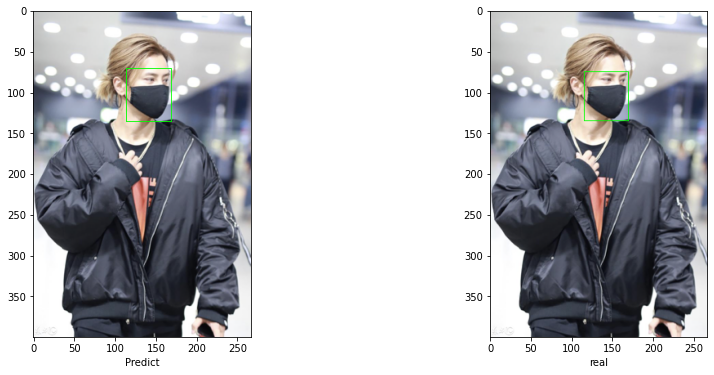

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


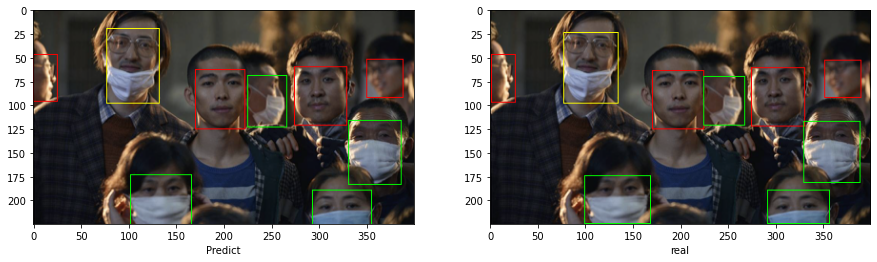

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


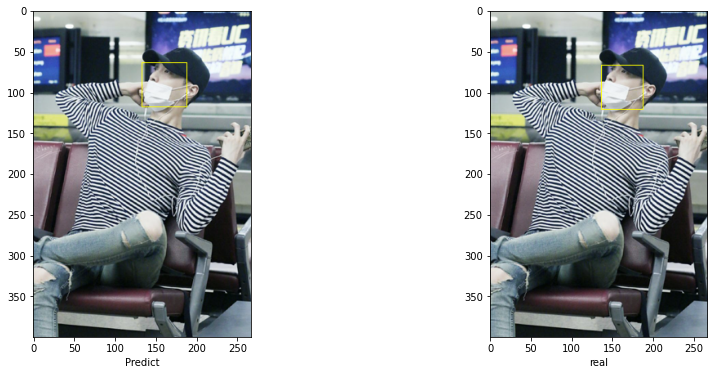

In [ ]:
from tarfile import NUL

for idx in range(3) :
    idx = random.randint(1,len(file_list))
    test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

    # Prediction
    test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
    test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes,test_labels)

    # Draw the bounding box of ground truth
    bbox, labels  = read_annot(file_list[idx], xml_path)
    #draw bounding boxes on the image
    gt_output, xmin, ymin, text = draw_boxes(test_img, bbox,labels)

    # Display the result
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_xlabel('Predict') # 모델의 예측 결과
    ax1.imshow(test_output)

    ax2.set_xlabel('real') # 실제 바운딩 박스 위치
    ax2.imshow(gt_output)
    plt.show()

### **사진에 라벨과 스코어 출력**

In [ ]:
def print_score(img, text_boxes, test_score):
  # Display the result
  fig, (ax1) = plt.subplots(1,figsize=(15,6))
  ax1.set_xlabel('Predict') # 모델의 예측 결과
  ax1.imshow(img)

  for i in range(len(test_boxes)):
    xmin = test_boxes[i][0]
    ymin = test_boxes[i][1]
    score = " : " + str(round(test_score[i], 2)) + "%"
    text_score = text[i] + score
    
    if text[i] == "without_mask":
      ax1.text(xmin + 50, ymin - 15, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='r')
    elif text[i] == "with_mask":
      ax1.text(xmin + 50, ymin - 15, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='b')
    else : 
      ax1.text(xmin + 50, ymin - 15, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='orange')

### **Mask Detection Test**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


with_mask


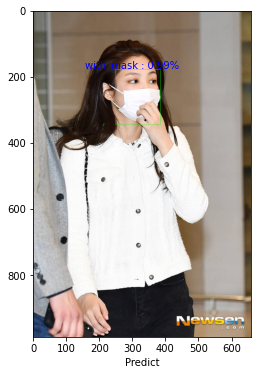

In [ ]:
url = 'https://img2.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/201903/07/newsen/20190307174830831bbvb.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
#print(test_score)
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

# Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]


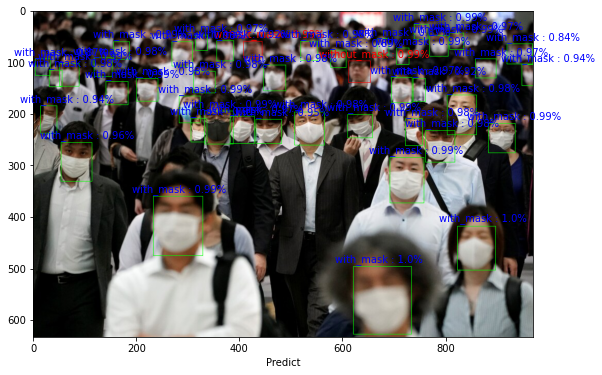

In [ ]:
url = 'http://flexible.img.hani.co.kr/flexible/normal/970/633/imgdb/original/2020/0529/5815907375869244.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

 # Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
#print(test_score)
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

# Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


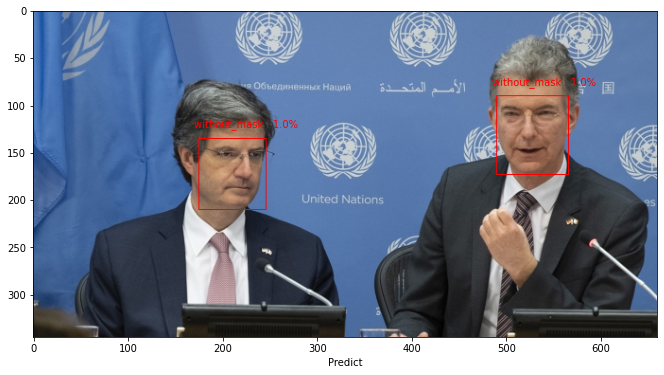

In [ ]:
url = 'https://img.seoul.co.kr/img/upload/2019/03/02/SSI_20190302101853_O2.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

 # Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
#print(test_score)
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

# Display the result
print_score(test_output, test_boxes, test_score)
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mask_weared_incorrect


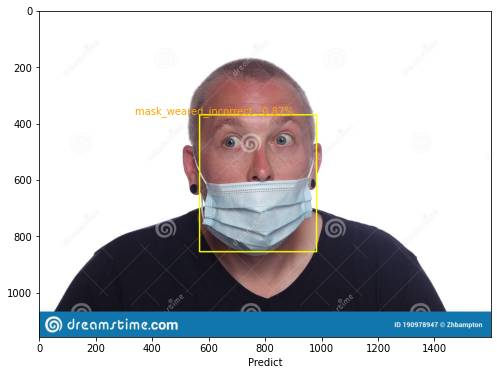

In [ ]:
url = 'https://thumbs.dreamstime.com/z/man-wearing-medical-protective-face-mask-incorrectly-close-up-face-young-man-wearing-medical-mask-wrong-way-isolated-190978947.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

 # Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
#print(test_score)
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels, thickness=3)

# Display the result
print_score(test_output, test_boxes, test_score)
  
